# Определение возраста покупателей

**Описание проекта:**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта:**
Построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

**Задачи:**
- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Рассмотрим подробнее датасет *labels*.

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
labels.shape

(7591, 2)

В таблице содержатся данные о 7591 фотографии. Пропусков данных нет. В датафрейме 2 признака: `file_name` с именами файлов и целевой признак `real_age` с возрастами людей, изображенных в файлах. Целевой признак имеет целочисленные значения, где каждое число означает год. Средний возраст людей на них — 31 год, медианный возраст — 29 лет. Есть фотографии людей с возрастом 1 год и 100 лет. 

Построим гистограмму возраста людей на фотографиях.

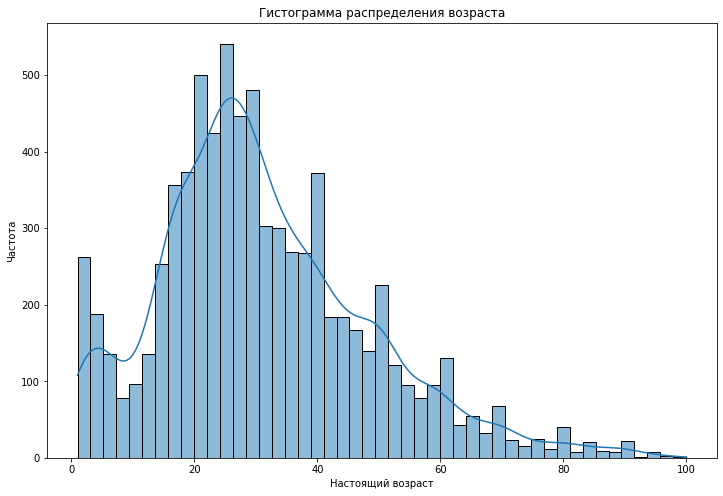

In [6]:
plt.figure(figsize=(12, 8))
sns.histplot(data=labels, x='real_age', kde=True)
plt.title('Гистограмма распределения возраста')
plt.xlabel('Настоящий возраст')
plt.ylabel('Частота')
plt.show()

По гистограмме видно, что данные распределены ненормально от 1 до 100 лет с большим всплеском ближе к нулю. Пик распределения расположен на значении возраста в 25-30 лет. Медиана приходится на возраст 29 лет.
Также наблюдаются отдельные всплески в значениях возрастов кратных 5. Это может свидетельствовать о возможном округлении целевых значений возрастов при их разметке. 

Рассмотрим случайные картинки из нашего датасета, а также убедимся в правильности разметки целевого признака по ним.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

In [ ]:
images, labels = next(train_gen_flow)

plt.figure(figsize=(15, 20))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(images[i])
    plt.title(f'Label(Age): {labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

**Вывод:** Таким образом, в процессе выполнения исследовательского анализа данных были получены следующие результаты:

- В таблице содержатся записи о 7591 фотографии. Средний возраст людей на них — 31 год, медианный возраст — 29 лет. Есть фотографии людей с возрастом 1 год и 100 лет. 

- Данные распределены ненормально от 1 до 100 лет с большим всплеском ближе к нулю. Пик распределения расположен на значении возраста в 25-30 лет. 

- Фотографии ранее обработаны таким образом, что лица расположены практически вертикально и занимают большую часть изображения. Это означает, что не требуется дополнительная обработка изображений. Достаточно использовать аугментацию в процессе подготовки тренировочных данных.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=45,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4], 
    fill_mode='reflect'
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        target_size=(224, 224),
        x_col='file_name',
        y_col='real_age',
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345
    )
    return train_generator

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.2,
        rescale=1./255)
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        target_size=(224, 224),
        x_col='file_name',
        y_col='real_age',
        batch_size=32,
        class_mode='raw',
        subset='validation',
        shuffle=False,
        seed=12345
    )
    return test_generator

def create_model(input_shape=(224, 224, 3)):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model

```

```

Train for 190 steps, validate for 48 steps
Epoch 1/10
190/190 - 164s - loss: 390.6204 - mae: 14.7898 - val_loss: 513.5368 - val_mae: 17.4612
Epoch 2/10
190/190 - 120s - loss: 158.2750 - mae: 9.5556 - val_loss: 626.4507 - val_mae: 19.7913
Epoch 3/10
190/190 - 120s - loss: 136.5410 - mae: 8.8673 - val_loss: 260.9318 - val_mae: 11.8654
Epoch 4/10
190/190 - 124s - loss: 123.2722 - mae: 8.3651 - val_loss: 117.8208 - val_mae: 8.2835
Epoch 5/10
190/190 - 133s - loss: 113.5279 - mae: 8.1051 - val_loss: 87.9478 - val_mae: 7.2298
Epoch 6/10
190/190 - 126s - loss: 106.3773 - mae: 7.7975 - val_loss: 78.8947 - val_mae: 6.5944
Epoch 7/10
190/190 - 119s - loss: 102.0992 - mae: 7.6600 - val_loss: 86.8422 - val_mae: 7.1774
Epoch 8/10
Epoch 9/10
190/190 - 120s - loss: 94.2131 - mae: 7.3507 - val_loss: 113.5896 - val_mae: 7.6782
190/190 - 121s - loss: 89.4169 - mae: 7.1932 - val_loss: 74.8827 - val_mae: 6.6658
Epoch 10/10
190/190 - 119s - loss: 84.1882 - mae: 6.9686 - val_loss: 84.5017 - val_mae: 6.8359

48/48 - 9s - loss: 84.5017 - mae: 6.8359

```

**Вывод:** 

Цель обучения нейросети достигнута. В результате выполнения кода, созданной нейросети на GPU с валидационными данными, получено значение показателя «MAE» равного 6.8359. Это меньше целевого значания 8. Так как «MAE» измеряется в абсолютных величинах, то полученый результат означает, что созданная модель ошибается в предсказании возраста человека по его фотографиии в среднем на 6.9589 лет.

## Анализ обученной модели

Супермаркету "Хлеб-Соль" необходима система компьютерного зрения для двух целей:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Для первой задачи наша модель подходит, так как её качества хватает, чтобы выделять отдельные категории покупателей по возрасту (молодежь, взрослые, пожилые и т.д.) и предлагать соответствующие товары.

Однако для строгого контроля (например, проверки возраста при продаже алкоголя) точности модели недостаточно. Ошибка в 6,8 лет критична: например, покупатель 20 лет может быть ошибочно классифицирован как 27-летний (продажа разрешена), а 17-летний — как 24-летний (незаконная продажа). Как альтернативу, модель можно использовать для предварительного отбора подозрительных случаев. Например:

- Фиксировать все продажи алкоголя покупателям с предсказанным возрастом до 30 лет,

- Передавать эти случаи на ручную проверку ответственным сотрудникам.